In [51]:
import re
import numpy as np
from tqdm import tqdm
import networkx as nx
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [23]:
# get paths of all downloaded character files
path_list = glob('./data/wow_chars/*.txt')

# get names of all downloaded characters
name_list = [
    path.split('\\')[-1].replace('.txt', '').replace('_', ' ') 
    for path in path_list
]

In [46]:
def fix_attr(attr):
    if attr:
        return attr[0]
    else:
        return  'Undefined'

In [49]:
G = nx.DiGraph()
for name, path in zip(name_list, path_list):
    # read text from downloaded character file 
    with open(path, 'r', encoding='utf-8') as f:
        txt = f.read()
    
    # extract information about the character
    gender = fix_attr(re.findall(r'gender = (\w+)', txt))
    type_ = fix_attr(re.findall(r'type = (\w+)', txt))
    race = fix_attr(re.findall(r'race = (\w+)', txt))
    faction = fix_attr(re.findall(r'faction = (\w+)', txt))
    status = fix_attr(re.findall(r'status = (\w+)', txt))
    resource = fix_attr(re.findall(r'resource = (\w+)', txt))

    # add node with attributes
    G.add_node(
        name, gender=gender, 
        type=type_, race=race, 
        faction=faction, status=status, 
        resource=resource
    )

    # find all links on page
    links = np.unique(re.findall(r'\[\[(.*?)(?:[\|#].*?)?\]\]', txt))

    # add edges
    for link in links:
        if link in name_list:
            G.add_edge(name, link)

# create a new graph from the largest component in G
Gcc = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()

# save graphs
nx.write_gexf(G, './saved_graphs/G_wow.gexf')
nx.write_gexf(Gcc, './saved_graphs/Gcc_wow.gexf')

# print quick info
print(f'\t\tG\tGcc')
print(f"# of nodes:\t{len(list(G.nodes))}\t{len(list(Gcc.nodes))}")
print(f"# of links:\t{len(list(G.edges))}\t{len(list(Gcc.edges))}")

		G	Gcc
# of nodes:	267	264
# of links:	4019	4018


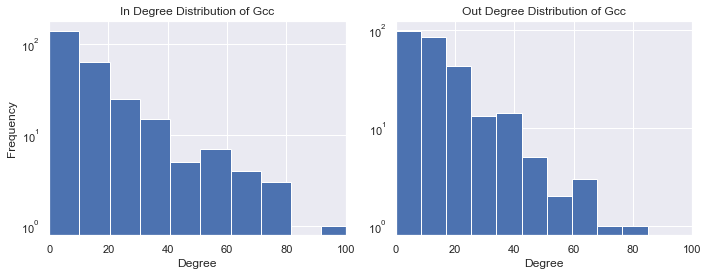

In [56]:
# Get arrays of out- and in-degrees for plotting
out_deg = np.array([v for _, v in Gcc.out_degree])
in_deg = np.array([v for _, v in Gcc.in_degree])

# also get total degrees as it is needed later
tot_deg = np.array([v for _, v in Gcc.degree])

# Create histograms of in and out degree distributions
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(in_deg, bins=10)
ax[1].hist(out_deg, bins=10)

ax[0].set_title('In Degree Distribution of Gcc')
ax[1].set_title('Out Degree Distribution of Gcc')

ax[0].set_ylabel('Frequency')
ax[1].set_yticks([])
for i in range(2):
    ax[i].set_xlabel('Degree')
    ax[i].set_yscale('log')
    ax[i].set_xlim([0, 100])
plt.tight_layout()
plt.show()